**<h3>1 Water pump prediction<h3>**

**1.1 Library insertion**

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

**1.2 Data insertion**

In [2]:
training_data_value = pd.read_csv("Training_set_values.csv")
training_data_label = pd.read_csv("Training_set_labels.csv")
testing_data = pd.read_csv("Test_set_values.csv")

# merge data
Merged_training_data = pd.merge(training_data_value,training_data_label, on="id")
All_data = pd.concat([testing_data, Merged_training_data])
All_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


**1.3 Support function**

In [3]:
# support function for numerical data, for analysis whole dataframe
def numerical_analysis(dataFrame):
  
  # Only select numerical columns
  numerical = dataFrame.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
  
  #data type
  data_types = pd.DataFrame(dataFrame[numerical].dtypes,columns=['Data Type'])

  # number of data count
  count_val = pd.DataFrame(columns=['Count'])

  for row in list(dataFrame[numerical].columns.values):
      count_val.loc[row] = [dataFrame[numerical][row].count()]
    
  # missing data
  missing_data = pd.DataFrame(dataFrame[numerical].isnull().sum(),columns=['Missing Values'])

  # maximum value
  maximum_val = pd.DataFrame(columns=['Maximum'])

  for row in list(dataFrame[numerical].columns.values):
      maximum_val.loc[row] = [dataFrame[numerical][row].max()]
    
  # minimum value
  minimum_val = pd.DataFrame(columns=['Minimum'])

  for row in list(dataFrame[numerical].columns.values):
      minimum_val.loc[row] = [dataFrame[numerical][row].min()]
    
  # mean value
  mean_val= pd.DataFrame(columns=['Mean'])

  for row in list(dataFrame[numerical].columns.values):
      mean_val.loc[row] = [dataFrame[numerical][row].mean()]

  # standard deviation value
  sd_val = pd.DataFrame(columns=['Standard Deviation'])

  for row in list(dataFrame[numerical].columns.values):
      sd_val.loc[row] = [dataFrame[numerical][row].std()]

  # mode
  mode_val = pd.DataFrame(columns=['Mode'])

  for row in list(dataFrame[numerical].columns.values): 
    mode_val.loc[row] = [dataFrame[numerical][row].mode()[0]]
    mode_0 = mode_val.loc[row]
  
  # mode frequency
  count_f_list = []

  for row in numerical:
    mode_0 = dataFrame[row].mode().iat[0]
    count_f = dataFrame[row].value_counts()[mode_0]
    count_f_list.append(count_f)

  count_f_list = np.array(count_f_list)
    
  # First quartile
  IqR_1 = pd.DataFrame(columns=['1st Quartile'])

  for row in list(dataFrame[numerical].columns.values):
      IqR_1.loc[row] = [dataFrame[numerical][row].quantile(0.25)]
    
  # Median
  median = pd.DataFrame(columns=['Median'])

  for row in list(dataFrame[numerical].columns.values):
    median.loc[row] = [dataFrame[numerical][row].quantile(0.5)]
    
  # Third quartile
  IqR_3 = pd.DataFrame(columns=['3rd Quartile'])

  for row in list(dataFrame[numerical].columns.values):
    IqR_3.loc[row] = [dataFrame[numerical][row].quantile(0.75)]

  # Unique values
  unique_val = pd.DataFrame(columns=['Unique Values'])

  for row in list(dataFrame[numerical].columns.values):
    unique_val.loc[row] = [dataFrame[numerical][row].nunique()]
  
    
  # join columns 
  result = data_types.join(count_val).join(missing_data).join(unique_val).join(minimum_val).join(maximum_val).join(mean_val).join(sd_val).join(IqR_1).join(median).join(IqR_3).join(mode_val)
  
  # percentage missing
  result['Missing in %'] = (result['Missing Values'] / len(dataFrame[numerical]) *100)
  
  # alternative mode calculation
  result['Mode freq'] = count_f_list 
  result['Mode in %'] = (result['Mode freq'] / result['Count']*100).astype('float')


  # change order of columns
  result = result[['Data Type', 'Count', 'Missing Values', 'Missing in %','Unique Values', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode', 'Mode freq','Mode in %']]

  #round
  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum','Mode freq','Mode in %','Mode']] =  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode freq','Mode in %','Mode']].round(1)
  
   
  #rreturn report
  return(result)


In [4]:
num_analysis = numerical_analysis(All_data)
num_analysis

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
id,int64,74250,0,0.0,74250,37124.5,21434.3,0.0,18562.2,37124.5,55686.8,74249.0,0.0,1,0.0
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6
population,int64,74250,0,0.0,1128,180.8,471.1,0.0,0.0,25.0,215.0,30500.0,0.0,26834,36.1
construction_year,int64,74250,0,0.0,55,1298.5,952.3,0.0,0.0,1986.0,2004.0,2013.0,0.0,25969,35.0


In [5]:
def categorical_analysis(dataFrame):

    # Select categorical columns
    cat_columns = dataFrame.select_dtypes(include='object').columns.tolist()

    # Data types
    data_types = pd.DataFrame(dataFrame[cat_columns].dtypes,columns=['Data Type'])


    # Missing data
    missing_df = pd.DataFrame(dataFrame[cat_columns].isnull().sum(),columns=['Missing Values'])

    # Record counts
    records_df = pd.DataFrame(columns=['Records'])

    for col in list(dataFrame[cat_columns].columns.values):
        records_df.loc[col] = [dataFrame[cat_columns][col].count()]

    # Unique values
    unique_val = pd.DataFrame(columns=['Unique Values'])
    for col in list(dataFrame[cat_columns].columns.values):
        unique_val.loc[col] = [dataFrame[cat_columns][col].nunique()]

    # Mode
    mode_df = pd.DataFrame(columns=['Mode'])

    for col in list(dataFrame[cat_columns].columns.values):
        mode_df.loc[col] = [dataFrame[cat_columns][col].mode()[0]]

    # Mode frequency
    mode_freq_list = []
    for col in cat_columns:
        mode_val = dataFrame[col].mode().iat[0]
        freq = dataFrame[col].value_counts()[mode_val]
        mode_freq_list.append(freq)
    mode_freq_array = np.array(mode_freq_list)

    # Create data quality report
    result = data_types.join(missing_df).join(records_df).join(unique_val).join(mode_df)
    result['Mode freq'] = mode_freq_array
    result['Mode in %'] = (result['Mode freq'] / result['Records'] * 100).astype('float')
    result['Missing in %'] = (result['Missing Values'] / len(dataFrame[cat_columns]) * 100)

    # Change order of columns
    result = result[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing in %', 'Mode', 'Mode freq', 'Mode in %']]
    result[['Missing in %', 'Mode in %']] = result[['Missing in %', 'Mode in %']].round(1)

    # Return report
    return result

In [6]:
cat_analysis = categorical_analysis(All_data)
cat_analysis

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,369,0,0.0,2011-03-17,695,0.9
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2
installer,object,69718,2410,4532,6.1,DWE,21751,31.2
wpt_name,object,74248,45683,2,0.0,none,4440,6.0
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9
region,object,74250,21,0,0.0,Iringa,6599,8.9
lga,object,74250,125,0,0.0,Njombe,3128,4.2
ward,object,74250,2098,0,0.0,Igosi,386,0.5
public_meeting,object,70095,2,4155,5.6,True,63749,90.9


In [7]:
# check duplicate 
def check_duplicate(dataFrame):
  duplicates = dataFrame.duplicated(keep = 'first').sum()
  print("No. duplicates: {}".format(duplicates))
  print("Total counts: {}".format(len(dataFrame)))
  print("Duplicated in %: {}".format((duplicates/len(dataFrame))*100))

In [8]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


**<h3>2 EDA - Preview<h3>**

**2.1 Duplication**

In [9]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


**<h3>3 EDA - Data Features<h3>**

**3.1 scheme_management**

In [10]:
cat_analysis.loc[['scheme_management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
scheme_management,object,69403,11,4847,6.5,VWC,45917,66.2


In [11]:
All_data['scheme_management'].isna().sum()

4847

In [12]:
# Fill Nan with 'Unknown'
All_data = All_data.fillna({'scheme_management': 'Unknown'})

In [13]:
All_data['scheme_management'].isna().sum()

0

**3.2 management**

In [14]:
cat_analysis.loc[['management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management,object,74250,12,0,0.0,vwc,50624,68.2


In [15]:
All_data['management'].isna().sum()

0

**3.3 management_group**

In [16]:
cat_analysis.loc[['management_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management_group,object,74250,5,0,0.0,user-group,65538,88.3


In [17]:
All_data['management_group'].isna().sum()

0

**3.4 payment**

In [67]:
cat_analysis.loc[['payment']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment,object,74250,7,0,0.0,never pay,31712,42.7


In [68]:
print(All_data['payment'].value_counts())

payment
never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: count, dtype: int64


**3.5 payment_type**

In [69]:
cat_analysis.loc[['payment_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment_type,object,74250,7,0,0.0,never pay,31712,42.7


In [70]:
print(All_data['payment_type'].value_counts())

payment_type
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: count, dtype: int64


In [71]:
# Map 'payment' values to 'payment_type' values
replacement_map = {
    'pay per bucket': 'per bucket',
    'pay monthly': 'monthly',
    'pay annually': 'annually',
    'never pay': 'never pay',
    'unknown': 'unknown',
    'pay when scheme fails': 'on failure',
    'other': 'other'
}

All_data['payment_standardized'] = All_data['payment'].replace(replacement_map)

In [72]:
# Check if the standardized payment column is the same as payment_type
All_data['comparison'] = All_data['payment_standardized'] == All_data['payment_type']
all_identical = All_data['comparison'].all()

print(f"All values identical: {all_identical}")

All values identical: True


**payment** and **payment_type** have the same values, so drop one of them. Here I drop the **payment** column.

In [73]:
 # Drop the original 'payment' column
All_data.drop(columns=['payment'], inplace=True)
All_data.drop(columns=['payment_standardized'], inplace=True)
All_data.drop(columns=['comparison'], inplace=True)

In [74]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['payment_type'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... management_water board management_wua management_wug  \
0  ...                      0

In [75]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_other', 'payment_type_per bucket',
       'payment_type_u

In [76]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'payment_type_annually')
calculate_zero_percentage(All_data, 'payment_type_monthly')
calculate_zero_percentage(All_data, 'payment_type_never pay')
calculate_zero_percentage(All_data, 'payment_type_on failure')
calculate_zero_percentage(All_data, 'payment_type_other')
calculate_zero_percentage(All_data, 'payment_type_per bucket')
calculate_zero_percentage(All_data, 'payment_type_unknown')

Percentage of 0s for payment_type_annually: 93.85%
Percentage of 0s for payment_type_monthly: 86.00%
Percentage of 0s for payment_type_never pay: 57.29%
Percentage of 0s for payment_type_on failure: 93.48%
Percentage of 0s for payment_type_other: 98.23%
Percentage of 0s for payment_type_per bucket: 84.83%
Percentage of 0s for payment_type_unknown: 86.33%


In [77]:
# Drop the 'payment_type_other'
All_data.drop(columns=['payment_type_other'], inplace=True)

In [78]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown'],
      dtype='object

**3.6 water_quality**

In [79]:
cat_analysis.loc[['water_quality']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
water_quality,object,74250,8,0,0.0,soft,63505,85.5


In [80]:
print(All_data['water_quality'].value_counts())

water_quality
soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: count, dtype: int64


**3.7 quality_group**

In [81]:
cat_analysis.loc[['quality_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quality_group,object,74250,6,0,0.0,good,63505,85.5


In [82]:
print(All_data['quality_group'].value_counts())

quality_group
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: count, dtype: int64


In [83]:
# Check mapping from water_quality to quality_group
mapping_check = All_data.groupby(['water_quality', 'quality_group']).size().reset_index(name='Count')
print(mapping_check)

        water_quality quality_group  Count
0            coloured       colored    623
1            fluoride      fluoride    244
2  fluoride abandoned      fluoride     23
3               milky         milky   1005
4               salty         salty   6082
5     salty abandoned         salty    423
6                soft          good  63505
7             unknown       unknown   2345


The relationship between `water_quality` and `quality_group` seems straightforward. Each `water_quality` corresponds to a specific `quality_group`, suggesting that `quality_group` is a more general classification of `water_quality`.

- **`water_quality`** has more subdivisions, including specific water quality descriptions such as fluoride (containing fluoride) and fluoride abandoned (abandoned containing fluoride). 
- **`quality_group`** provides a more simplified view, merging some subdivisions (such as classifying both fluoride and fluoride abandoned as fluoride). 

- If we choose to keep the more detailed `water_quality`, we may need to do some additional data processing, such as handling very rare categories or considering how to handle unknown categories. 
- If we choose to keep `quality_group`, we can reduce variables in the model to avoid overfitting and may improve processing speed and model generalization.

So we tend to keep the `quality_group`

**See visualiztion in next part**

**3.8 quantity**

In [91]:
cat_analysis.loc[['quantity']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity,object,74250,5,0,0.0,enough,41522,55.9


In [92]:
print(All_data['quantity'].value_counts())

quantity
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


**3.9 quantity_group**

In [93]:
cat_analysis.loc[['quantity_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity_group,object,74250,5,0,0.0,enough,41522,55.9


In [94]:
print(All_data['quantity_group'].value_counts())

quantity_group
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


In [95]:
same_values = (All_data['quantity'] == All_data['quantity_group']).all()
print("They have the same value：", same_values)

They have the same value： True


In [96]:
# Drop 'quantity_group' colunm
All_data.drop(columns=['quantity_group'], inplace=True)

In [97]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quantity'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... payment_type_unknown quality_group_good quality_group_milky  \
0  ...                

In [98]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'scheme_management_Unknown',
       'scheme_management_VWC', 'scheme_management_WUG',
       'scheme_management_Water authority', 'management_vwc',
       'management_water board', 'management_wua', 'management_wug',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_

In [99]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'quantity_dry')
calculate_zero_percentage(All_data, 'quantity_enough')
calculate_zero_percentage(All_data, 'quantity_insufficient')
calculate_zero_percentage(All_data, 'quantity_seasonal')
calculate_zero_percentage(All_data, 'quantity_unknown')

Percentage of 0s for quantity_dry: 89.52%
Percentage of 0s for quantity_enough: 44.08%
Percentage of 0s for quantity_insufficient: 74.55%
Percentage of 0s for quantity_seasonal: 93.16%
Percentage of 0s for quantity_unknown: 98.69%


**3.10 source**

In [100]:
cat_analysis.loc[['source']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source,object,74250,10,0,0.0,spring,21216,28.6


In [101]:
print(All_data['source'].value_counts())

source
spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: count, dtype: int64


**3.11 source_type**

In [102]:
cat_analysis.loc[['source_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_type,object,74250,7,0,0.0,spring,21216,28.6


In [103]:
print(All_data['source_type'].value_counts())

source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: count, dtype: int64


In [104]:
# Check mapping from source to source_type
mapping_check_source = All_data.groupby(['source', 'source_type']).size().reset_index(name='Count')
print(mapping_check_source)

                 source           source_type  Count
0                   dam                   dam    840
1              hand dtw              borehole   1108
2                  lake            river/lake    950
3           machine dbh              borehole  13822
4                 other                 other    261
5  rainwater harvesting  rainwater harvesting   2863
6                 river            river/lake  11964
7          shallow well          shallow well  21140
8                spring                spring  21216
9               unknown                 other     86


**3.12 source_class**

In [105]:
cat_analysis.loc[['source_class']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_class,object,74250,3,0,0.0,groundwater,57286,77.2


In [106]:
print(All_data['source_class'].value_counts())

source_class
groundwater    57286
surface        16617
unknown          347
Name: count, dtype: int64


**3.13 waterpoint_type**

In [118]:
cat_analysis.loc[['waterpoint_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type,object,74250,7,0,0.0,communal standpipe,35628,48.0


In [119]:
print(All_data['waterpoint_type'].value_counts())

waterpoint_type
communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: count, dtype: int64


**3.14 waterpoint_type_group**

In [120]:
cat_analysis.loc[['waterpoint_type_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type_group,object,74250,6,0,0.0,communal standpipe,43239,58.2


In [121]:
print(All_data['waterpoint_type_group'].value_counts())

waterpoint_type_group
communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: count, dtype: int64


In [122]:
# Check mapping from waterpoint_type to waterpoint_type_group
mapping_check_waterpoint = All_data.groupby(['waterpoint_type', 'waterpoint_type_group']).size().reset_index(name='Count')
print(mapping_check_waterpoint)

               waterpoint_type waterpoint_type_group  Count
0                cattle trough         cattle trough    150
1           communal standpipe    communal standpipe  35628
2  communal standpipe multiple    communal standpipe   7611
3                          dam                   dam      8
4                    hand pump             hand pump  21884
5              improved spring       improved spring    959
6                        other                 other   8010


**<h3>4 Visualization<h3>**

**4.1 scheme_management, management, management_group**

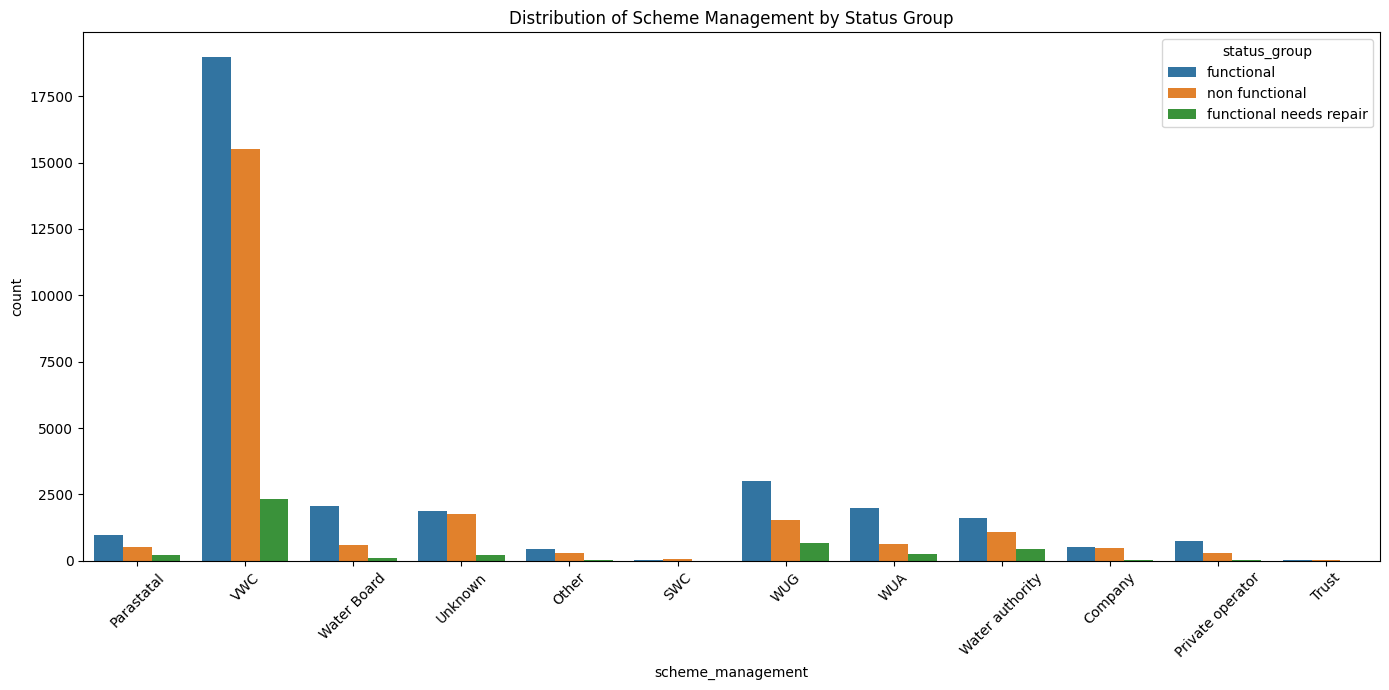

In [19]:
# Create a count graph to see the impact of scheme_management on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='scheme_management', hue='status_group', data=All_data)
plt.title('Distribution of Scheme Management by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

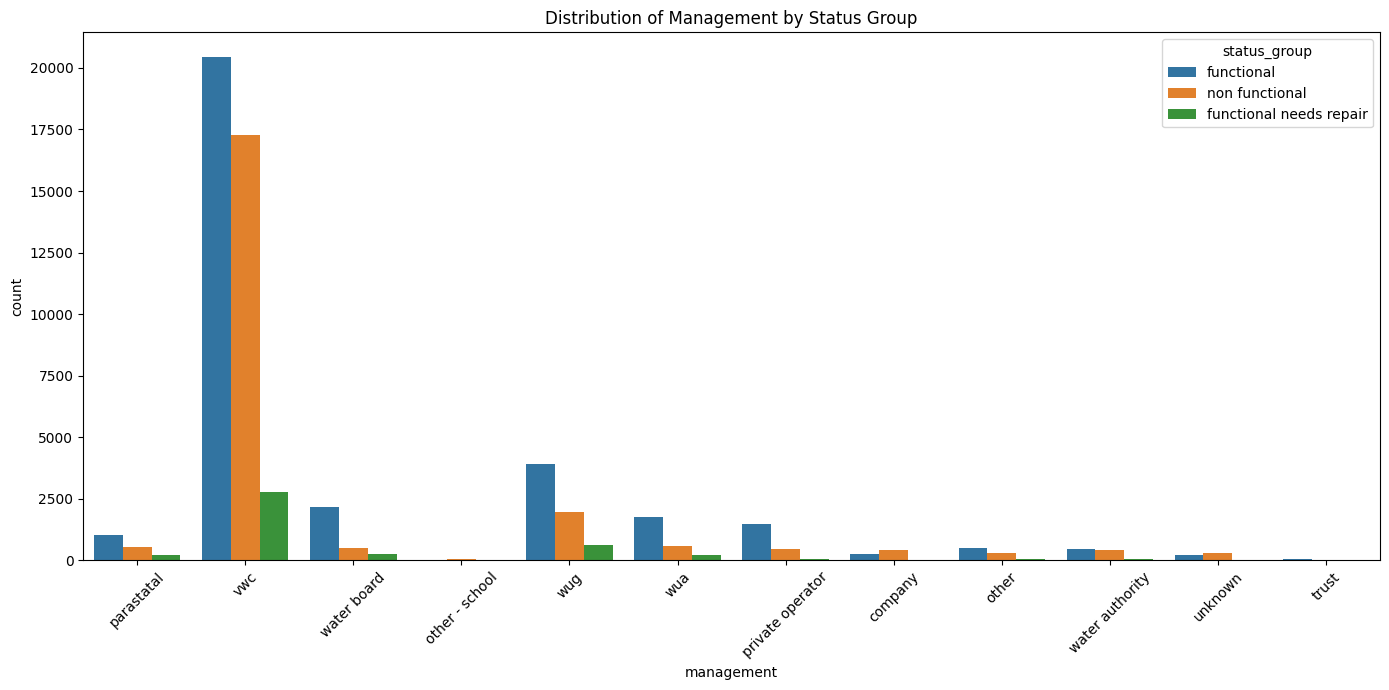

In [20]:
# Create a count graph to see the impact of management on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='management', hue='status_group', data=All_data)
plt.title('Distribution of Management by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

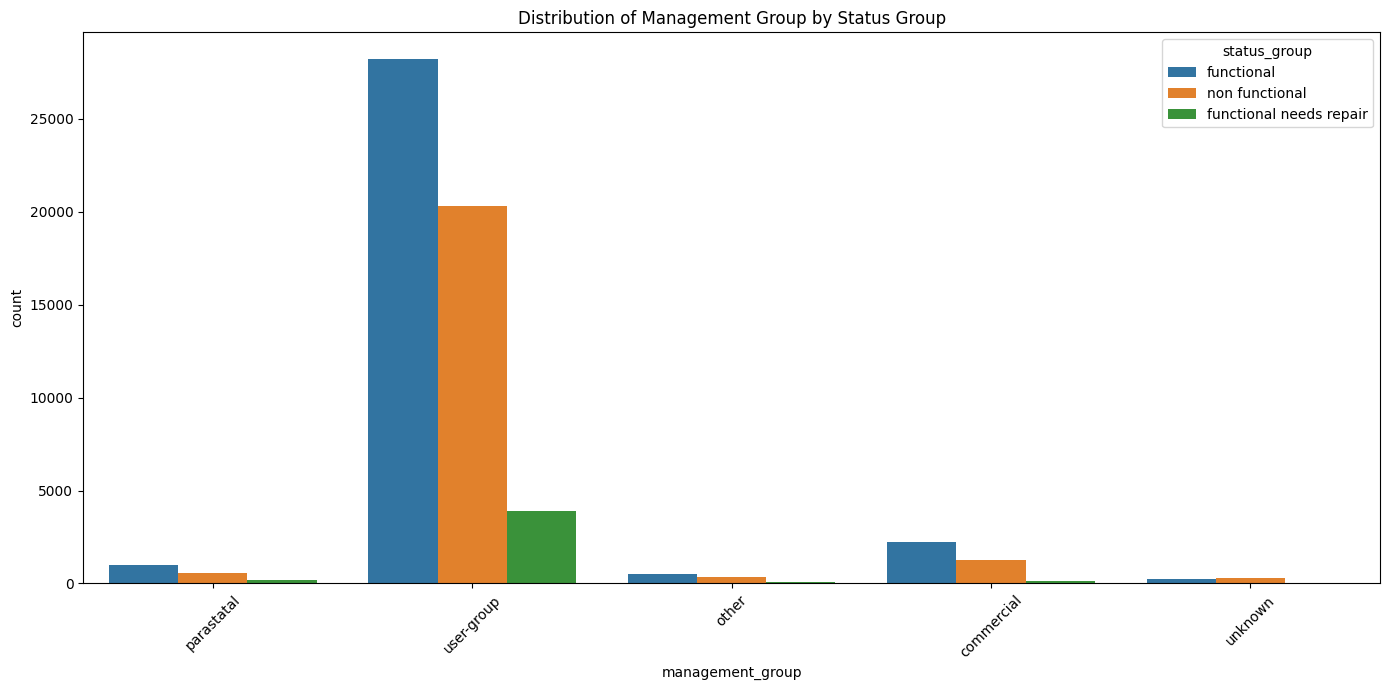

In [21]:
# Create a count graph to see the impact of management_group on status_group
plt.figure(figsize=(14, 7))
sns.countplot(x='management_group', hue='status_group', data=All_data)
plt.title('Distribution of Management Group by Status Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

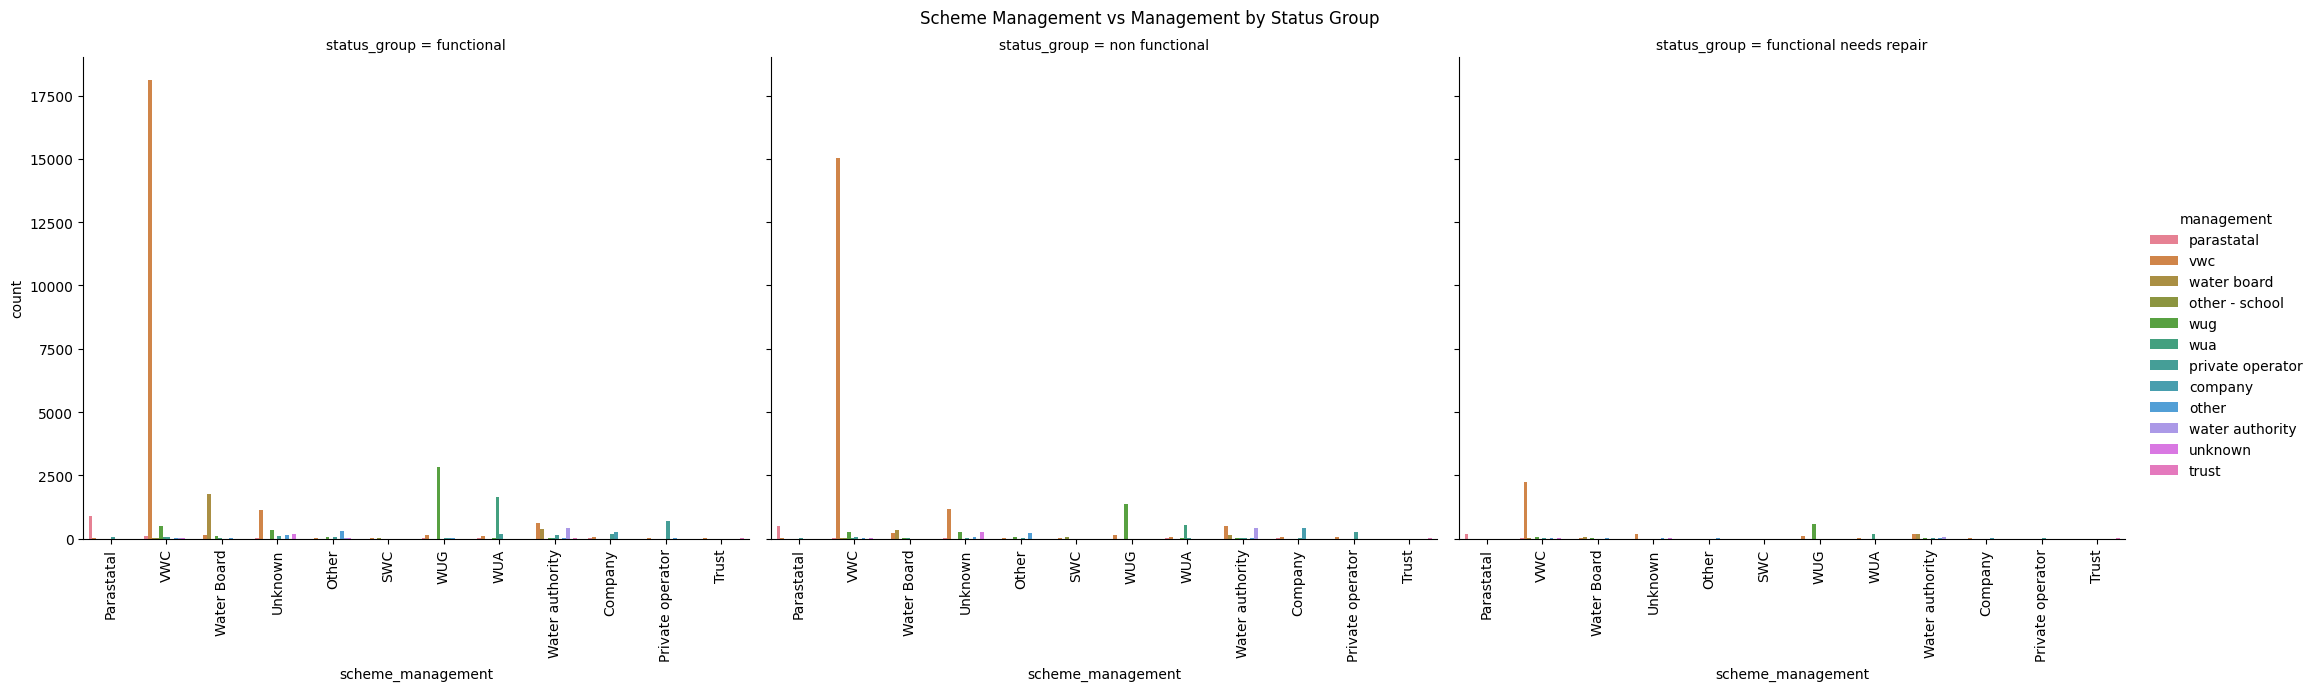

<Figure size 1600x1000 with 0 Axes>

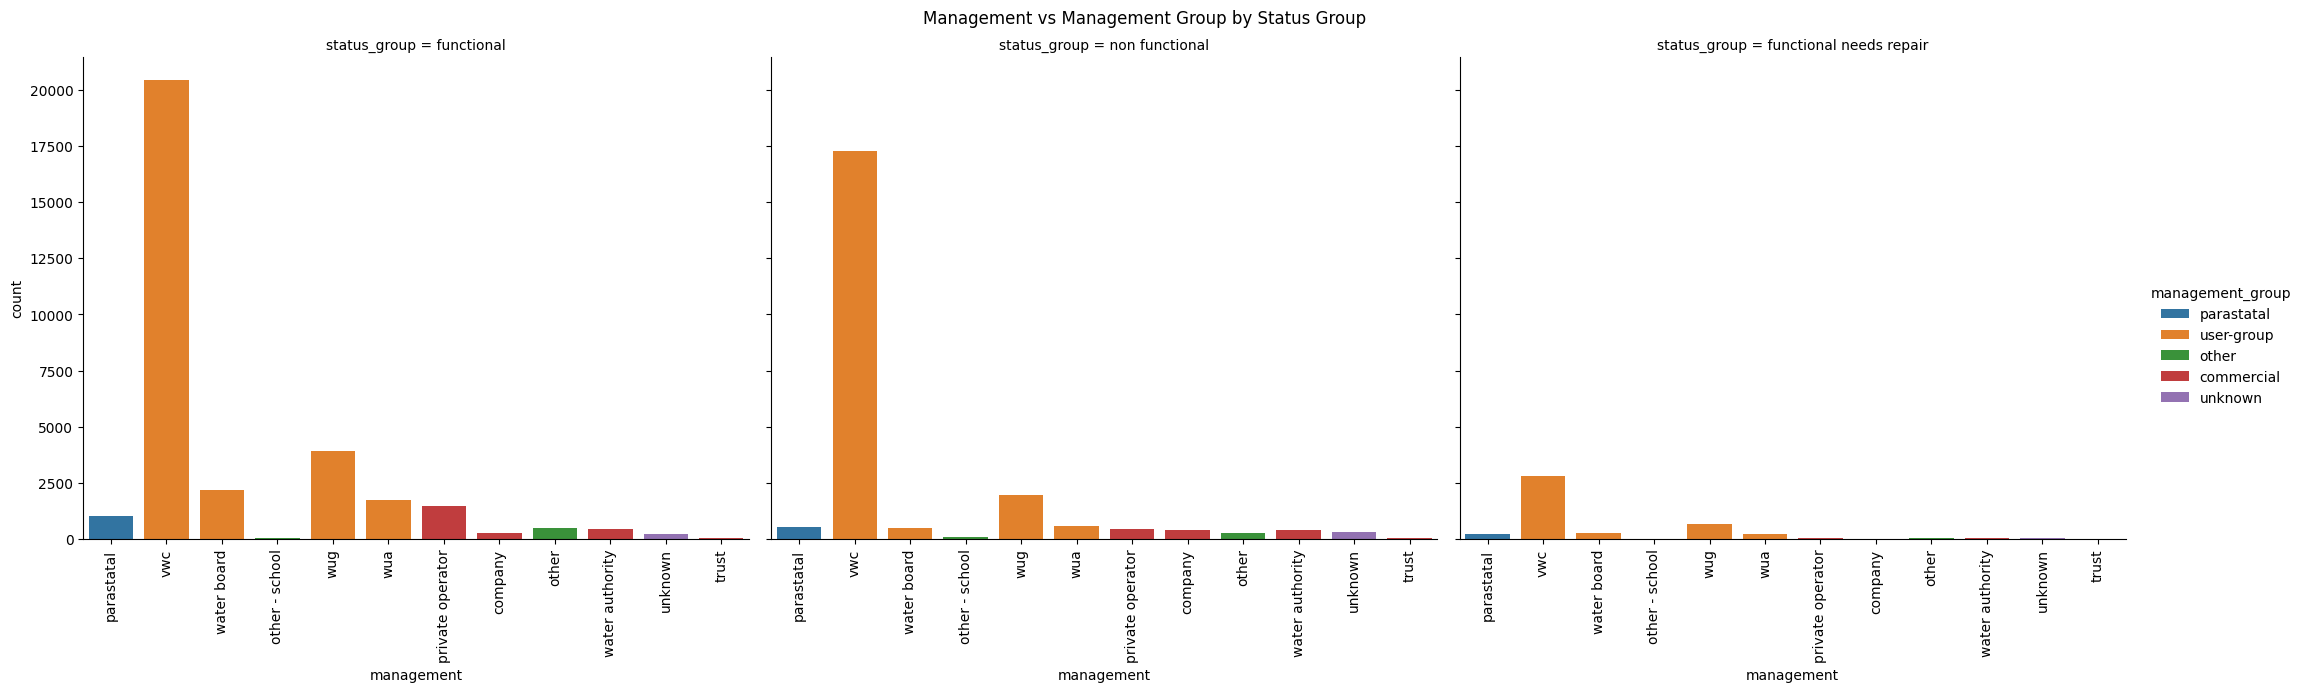

<Figure size 1600x1000 with 0 Axes>

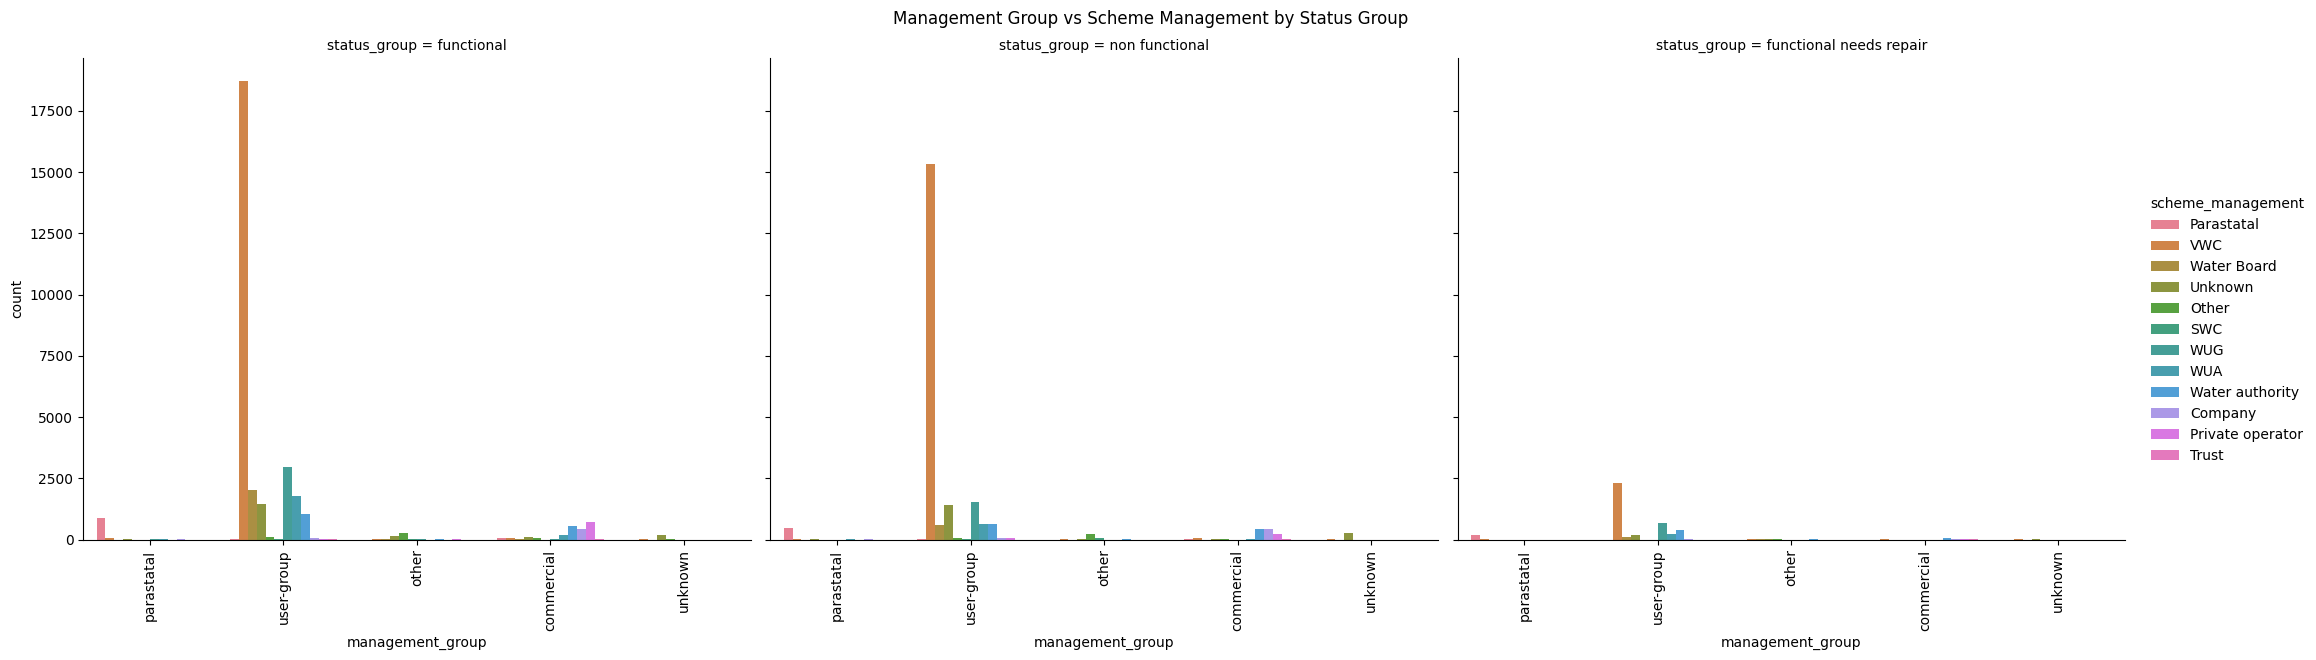

In [22]:
# scheme_management and management
plt.figure(figsize=(16, 10))
g = sns.catplot(x="scheme_management", hue="management", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scheme Management vs Management by Status Group')
plt.show()

# management and management_group
plt.figure(figsize=(16, 10))
g = sns.catplot(x="management", hue="management_group", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Management vs Management Group by Status Group')
plt.show()

# management_group and scheme_management
plt.figure(figsize=(16, 10))
g = sns.catplot(x="management_group", hue="scheme_management", col="status_group",
                data=All_data, kind="count",
                height=6, aspect=1.2)
g.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Management Group vs Scheme Management by Status Group')
plt.show()

Analyzing the bi-variate plots using combinations of `scheme_management`, `management`, and `management_group` in relation to `status_group`, here’s a breakdown of insights and a suggestion on which variable might be the most redundant:

### Analysis of Plots:

1. **Scheme Management vs Management**:
   - This plot shows significant differentiation between different `scheme_management` categories and their associated `management` styles. Each management scheme, such as Parastatal, WUG, and Water Board, tends to have varied management types, indicating unique combinations that likely offer distinct insights.

2. **Management vs Management Group**:
   - There seems to be a substantial overlap in categories. For instance, most `management` categories like WUA, WUG, and Water Board are dominated by a single `management_group`, often the user-group. This suggests that the `management_group` is a high-level categorization which does not differentiate as finely as `management`.

3. **Management Group vs Scheme Management**:
   - Similar to the above, there appears to be strong overlap in how `scheme_management` and `management_group` are distributed across different status groups. Most `scheme_management` categories are predominantly associated with specific `management_group` categories, indicating redundancy.

### Conclusion:

From these observations:
- **Scheme Management vs Management** shows rich and varied combinations, which can provide deeper insights into how different management schemes and operational methods impact the functionality of water points.
- **Management vs Management Group** and **Management Group vs Scheme Management** both exhibit a high degree of overlap, suggesting redundancy between `management_group` and the other two variables.

### Suggested Variable to Remove:

- **`management_group`** appears to be the most appropriate variable to remove. It is less granular and its information seems largely encapsulated within both `scheme_management` and `management`. Removing `management_group` would likely retain most of the detailed insights provided by the finer distinctions within `management` and `scheme_management`.

Removing `management_group` should simplify the model or analysis without significant loss of information, as the more detailed variables (`management` and `scheme_management`) provide richer and more actionable insights into the operational status of water points. This approach should help in streamlining the analysis while preserving essential information for decision-making.

In [23]:
# Creating Crosstabs: Scheme Management vs Management
ct_scheme_management = pd.crosstab(All_data['scheme_management'], All_data['management'])

# Creating Crosstabs：Management vs Management Group
ct_management_mgmtgroup = pd.crosstab(All_data['management'], All_data['management_group'])

# Creating Crosstabs：Management Group vs Scheme Management
ct_mgmtgroup_scheme = pd.crosstab(All_data['management_group'], All_data['scheme_management'])


In [24]:
# Normalized Crosstab
ct_scheme_management_normalized = ct_scheme_management.div(ct_scheme_management.sum(axis=1), axis=0)
ct_management_mgmtgroup_normalized = ct_management_mgmtgroup.div(ct_management_mgmtgroup.sum(axis=1), axis=0)
ct_mgmtgroup_scheme_normalized = ct_mgmtgroup_scheme.div(ct_mgmtgroup_scheme.sum(axis=1), axis=0)

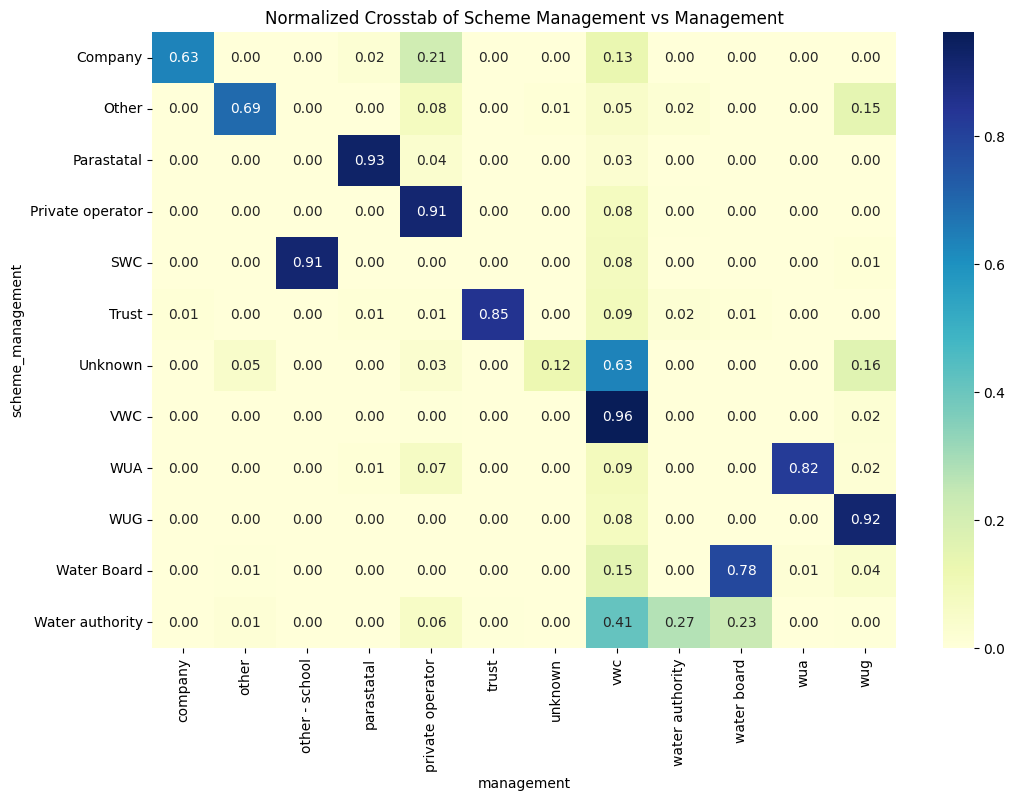

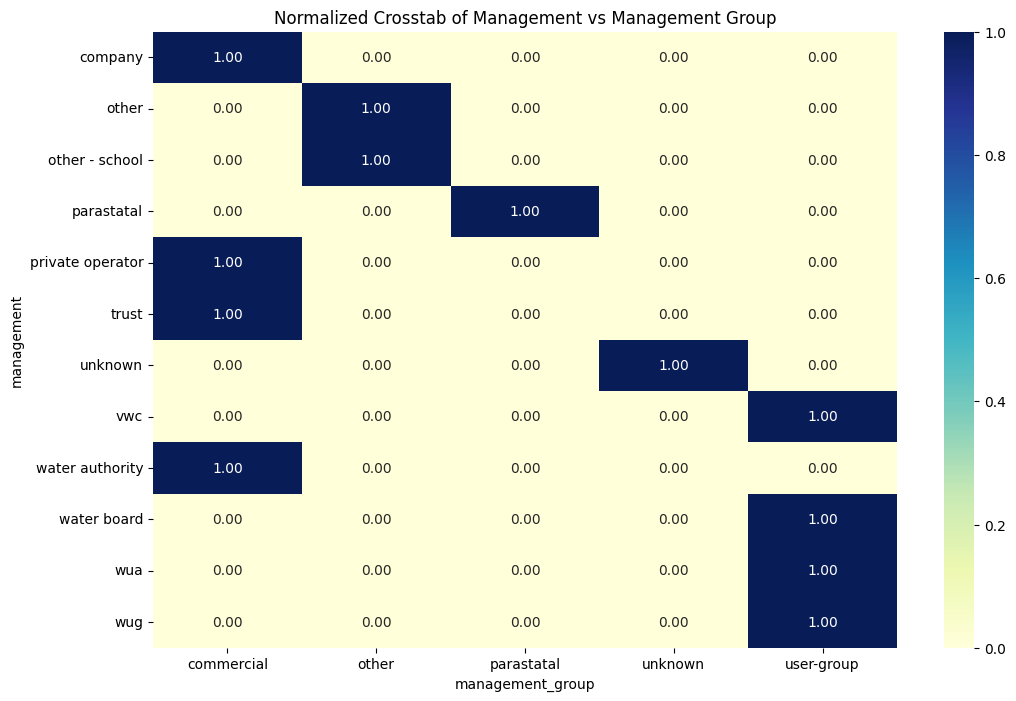

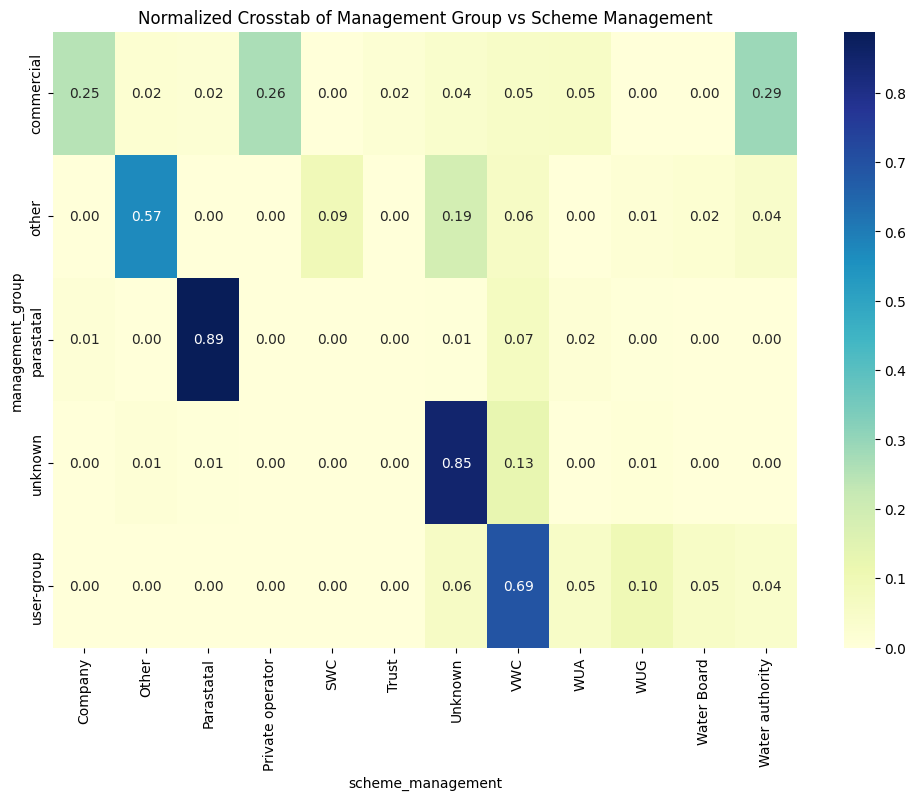

In [25]:
# Visualize Scheme Management vs Management
plt.figure(figsize=(12, 8))
sns.heatmap(ct_scheme_management_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Scheme Management vs Management')
plt.show()

# Visualize Management vs Management Group
plt.figure(figsize=(12, 8))
sns.heatmap(ct_management_mgmtgroup_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Management vs Management Group')
plt.show()

# Visualize Management Group vs Scheme Management
plt.figure(figsize=(12, 8))
sns.heatmap(ct_mgmtgroup_scheme_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Normalized Crosstab of Management Group vs Scheme Management')
plt.show()

### 1. Scheme Management vs Management

This chart shows the distribution between **Scheme Management** categories and **Management** categories. Observations reveal:

- Specific management schemes, such as Parastatal, SWC, Trust, Unknown, WUA, WUG, and Water Board, are highly correlated with specific management types, for example, Parastatal mostly aligns with Parastatal management type, while WUA and WUG are closely linked with the user-group.
- While each **Scheme Management** category has distinct tendencies towards certain **Management** categories, they still retain unique information. Therefore, both variables provide valuable, high-resolution data.

### 2. Management vs Management Group

This chart illustrates the relationship between **Management** and **Management Group**. The results show:

- Most management types correspond almost exclusively with a single management group, such as company, private operator, trust, water authority closely related to commercial, parastatal, etc.
- Because the relationship between **Management** and **Management Group** is very significant (almost a one-to-one correspondence), this suggests that at least one of the two variables is redundant because one variable almost perfectly predicts the value of the other.
- This indicates that **Management Group** essentially serves as a simplified or aggregated version of **Management**, with **Management** offering more granular information than **Management Group**.

### 3. Management Group vs Scheme Management

This chart shows the relationship between **Management Group** and **Scheme Management**. The findings demonstrate:

- Certain management groups are highly associated with specific management schemes, such as the user-group predominantly associated with WUG and WUA schemes, and parastatal with the Parastatal scheme.
- While there are evident associations, the relationship between management schemes and management groups is not as direct as between management types.

### Suggested Variable for Removal

Given the high overlap between **Management** and **Management Group**, where **Management** provides more detailed information and **Management Group** acts more like an abstract category, it is advisable to remove **Management Group**. Doing so will reduce redundancy in the data while retaining more specific management information which is beneficial for deeper analysis.

Removing **Management Group** also means keeping more detailed and informative **Scheme Management** and **Management** in the data model, which will help provide more precise management insights, advantageous for formulating or improving management strategies.

In [26]:
# Drop 'management_group' column
All_data.drop('management_group', axis=1, inplace=True)

In [27]:
# One Hot encoding
All_data = pd.get_dummies(All_data, columns=['scheme_management'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... scheme_management_Parastatal scheme_management_Private operator  \
0  ...            

In [41]:
# Print a list of all column names
print(All_data.columns)


Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Company', 'scheme_management_Other',
       'scheme_management_Parastatal', 'scheme_management_Private operator',
       'scheme_management_SWC', 'scheme_management_Trust',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUA', 'scheme_management_WUG',
       'scheme_management_Water Board', 'schem

In [58]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'scheme_management_Company')
calculate_zero_percentage(All_data, 'scheme_management_Other')
calculate_zero_percentage(All_data, 'scheme_management_Parastatal')
calculate_zero_percentage(All_data, 'scheme_management_Private operator')
calculate_zero_percentage(All_data, 'scheme_management_SWC')
calculate_zero_percentage(All_data, 'scheme_management_Trust')
calculate_zero_percentage(All_data, 'scheme_management_Unknown')
calculate_zero_percentage(All_data, 'scheme_management_VWC')
calculate_zero_percentage(All_data, 'scheme_management_WUA')
calculate_zero_percentage(All_data, 'scheme_management_WUG')
calculate_zero_percentage(All_data, 'scheme_management_Water Board')
calculate_zero_percentage(All_data, 'scheme_management_Water authority')

Percentage of 0s for scheme_management_Company: 98.19%
Percentage of 0s for scheme_management_Other: 98.66%
Percentage of 0s for scheme_management_Parastatal: 97.14%
Percentage of 0s for scheme_management_Private operator: 98.21%
Percentage of 0s for scheme_management_SWC: 99.83%
Percentage of 0s for scheme_management_Trust: 99.88%
Percentage of 0s for scheme_management_Unknown: 93.47%
Percentage of 0s for scheme_management_VWC: 38.16%
Percentage of 0s for scheme_management_WUA: 95.22%
Percentage of 0s for scheme_management_WUG: 91.25%
Percentage of 0s for scheme_management_Water Board: 95.34%
Percentage of 0s for scheme_management_Water authority: 94.65%


In [61]:
# Drop colunms that percentage of 0 is over 95%
All_data.drop('scheme_management_Company', axis=1, inplace=True)
All_data.drop('scheme_management_Other', axis=1, inplace=True)
All_data.drop('scheme_management_Parastatal', axis=1, inplace=True)
All_data.drop('scheme_management_Private operator', axis=1, inplace=True)
All_data.drop('scheme_management_SWC', axis=1, inplace=True)
All_data.drop('scheme_management_Trust', axis=1, inplace=True)
All_data.drop('scheme_management_WUA', axis=1, inplace=True)
All_data.drop('scheme_management_Water Board', axis=1, inplace=True)

In [62]:
# One Hot encoding
All_data = pd.get_dummies(All_data, columns=['management'], dtype='int_')
print(All_data.head())

KeyError: "None of [Index(['management'], dtype='object')] are in the [columns]"

In [63]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_company', 'management_other', 'management_other - school',
       'management_parastatal', 'management_private operator',
       'management_trust', 'management_unknown', 'management_vwc',
       'management_water authority', 'm

In [64]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'management_company')
calculate_zero_percentage(All_data, 'management_other')
calculate_zero_percentage(All_data, 'management_other - school')
calculate_zero_percentage(All_data, 'management_parastatal')
calculate_zero_percentage(All_data, 'management_private operator')
calculate_zero_percentage(All_data, 'management_trust')
calculate_zero_percentage(All_data, 'management_unknown')
calculate_zero_percentage(All_data, 'management_vwc')
calculate_zero_percentage(All_data, 'management_water authority')
calculate_zero_percentage(All_data, 'management_water board')
calculate_zero_percentage(All_data, 'management_wua')
calculate_zero_percentage(All_data, 'management_wug')

Percentage of 0s for management_company: 98.84%
Percentage of 0s for management_other: 98.54%
Percentage of 0s for management_other - school: 99.83%
Percentage of 0s for management_parastatal: 97.00%
Percentage of 0s for management_private operator: 96.63%
Percentage of 0s for management_trust: 99.86%
Percentage of 0s for management_unknown: 99.08%
Percentage of 0s for management_vwc: 31.82%
Percentage of 0s for management_water authority: 98.49%
Percentage of 0s for management_water board: 95.03%
Percentage of 0s for management_wua: 95.80%
Percentage of 0s for management_wug: 89.08%


In [65]:
# Drop colunms that percentage of 0 is over 95%. But keep the 'management_water board' and 'management_wua', since the percentage is close to 95%.
All_data.drop('management_company', axis=1, inplace=True)
All_data.drop('management_other', axis=1, inplace=True)
All_data.drop('management_other - school', axis=1, inplace=True)
All_data.drop('management_parastatal', axis=1, inplace=True)
All_data.drop('management_private operator', axis=1, inplace=True)
All_data.drop('management_trust', axis=1, inplace=True)
All_data.drop('management_unknown', axis=1, inplace=True)
All_data.drop('management_water authority', axis=1, inplace=True)

In [66]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug'],
      dtype='object')


**4.2 water_quality, quality_group**

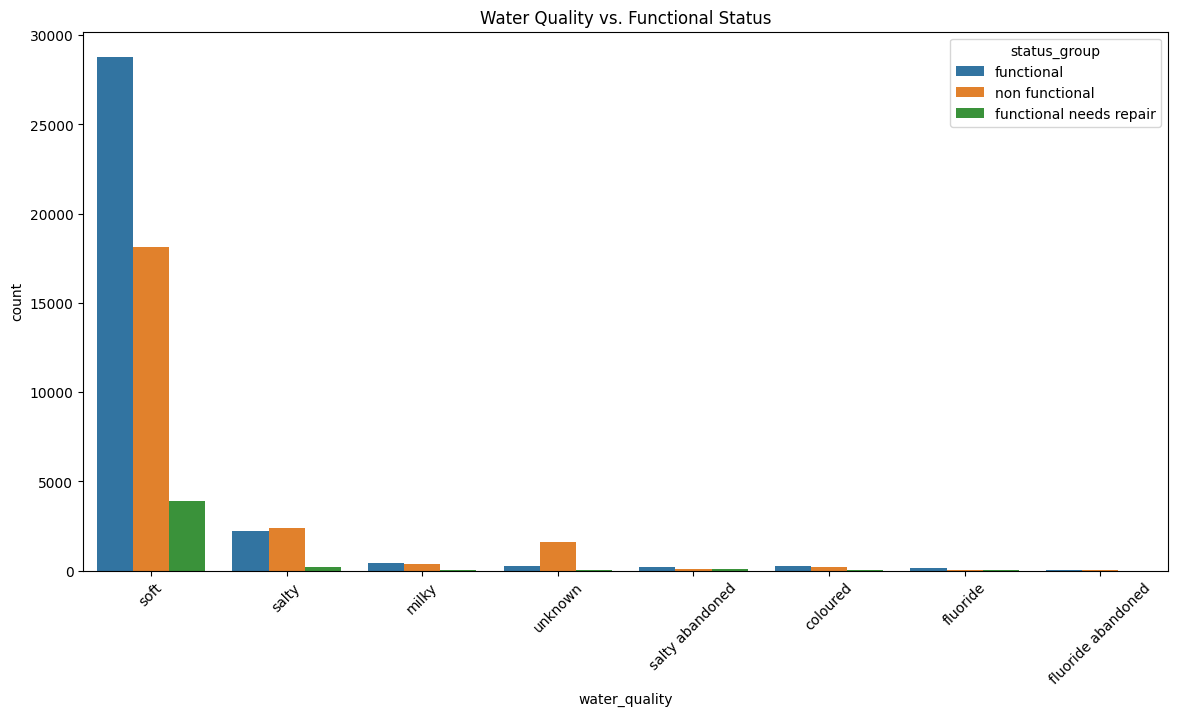

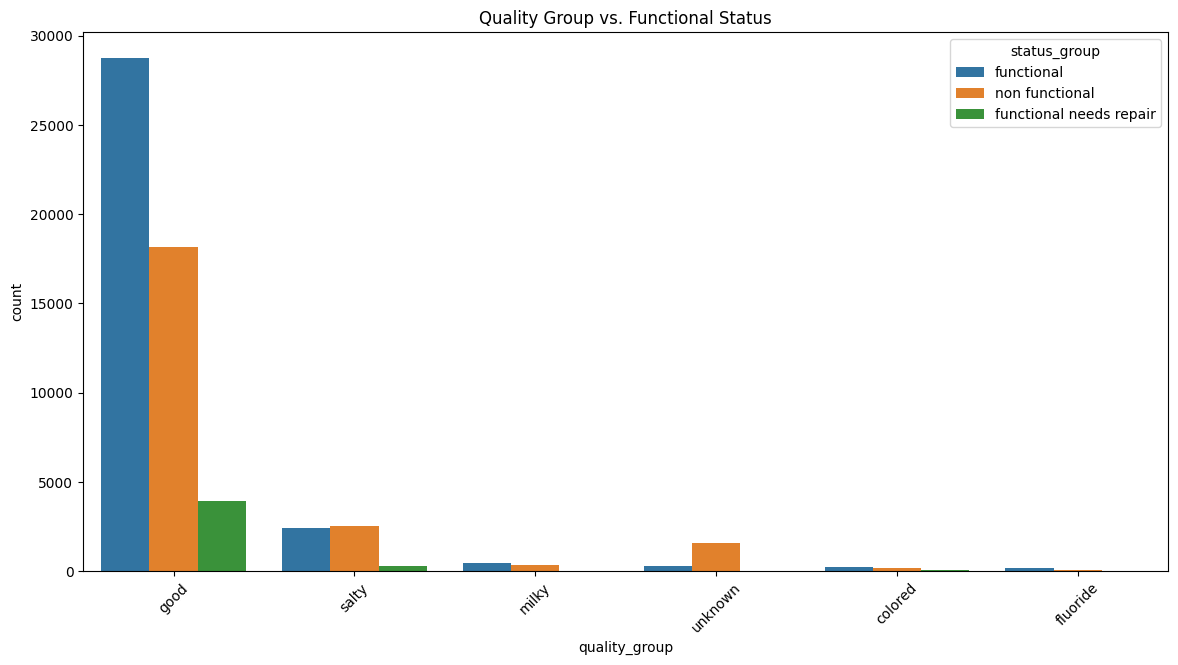

In [84]:
subset = All_data[['water_quality', 'quality_group', 'status_group']]

# Visualize water_quality vs status_group
plt.figure(figsize=(14, 7))
sns.countplot(data=subset, x='water_quality', hue='status_group')
plt.title('Water Quality vs. Functional Status')
plt.xticks(rotation=45)
plt.show()

# Visualize quality_group vs status_group
plt.figure(figsize=(14, 7))
sns.countplot(data=subset, x='quality_group', hue='status_group')
plt.title('Quality Group vs. Functional Status')
plt.xticks(rotation=45)
plt.show()

From the two visualizations you provided, we can observe the following:

**Water Quality** vs. **Functional Status**:

The **water_quality** variable provides a more detailed classification of water quality, and the distribution of each classification under different functional states (good function, non-functional, and needing repair). For example, soft water quality occupies most of the water points with good function, while other types such as salty and milky also have a certain distribution in the non-functional or needing repair states. 

**Water Quality Group vs. Functional Status**:

The classification of **quality_group** is broader, including good, salty, milky, etc. Although it can reflect the relationship with the functional status, its information is less detailed than water_quality. 


**Analysis suggestions**:

**water_quality** provides more details and may be more useful. For example, knowing clearly whether the water is salty or salty abandoned may be crucial for some analysis or decision-making. 

If the purpose of the project is to identify general categories of water quality and does not require very detailed classification, **quality_group** is sufficient to meet the needs while also simplifying the complexity of the model. 

Conclusion:
In these two figures, although **water_quality** provides more details, the information of **quality_group** is enough to reflect the impact of water quality on functional status in most cases. Therefore, keeping **quality_group** may be a more reasonable choice. This can simplify the dataset while maintaining important information about the functional status of water points.

In [85]:
# Drop the 'water_quality' colunm
All_data.drop(columns=['water_quality'], inplace=True)

In [86]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quality_group'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... payment_type_never pay payment_type_on failure payment_type_per bucket  \
0  ...     

In [87]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown',
       'quality_group_colored', 'quality_group_fluorid

In [88]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'quality_group_colored')
calculate_zero_percentage(All_data, 'quality_group_fluoride')
calculate_zero_percentage(All_data, 'quality_group_good')
calculate_zero_percentage(All_data, 'quality_group_milky')
calculate_zero_percentage(All_data, 'quality_group_salty')
calculate_zero_percentage(All_data, 'quality_group_unknown')

Percentage of 0s for quality_group_colored: 99.16%
Percentage of 0s for quality_group_fluoride: 99.64%
Percentage of 0s for quality_group_good: 14.47%
Percentage of 0s for quality_group_milky: 98.65%
Percentage of 0s for quality_group_salty: 91.24%
Percentage of 0s for quality_group_unknown: 96.84%


In [89]:
# Drop colunms that percentage of 0 is over 99%.
All_data.drop('quality_group_colored', axis=1, inplace=True)
All_data.drop('quality_group_fluoride', axis=1, inplace=True)

In [90]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'q

**4.3 source, source_type, source_class**

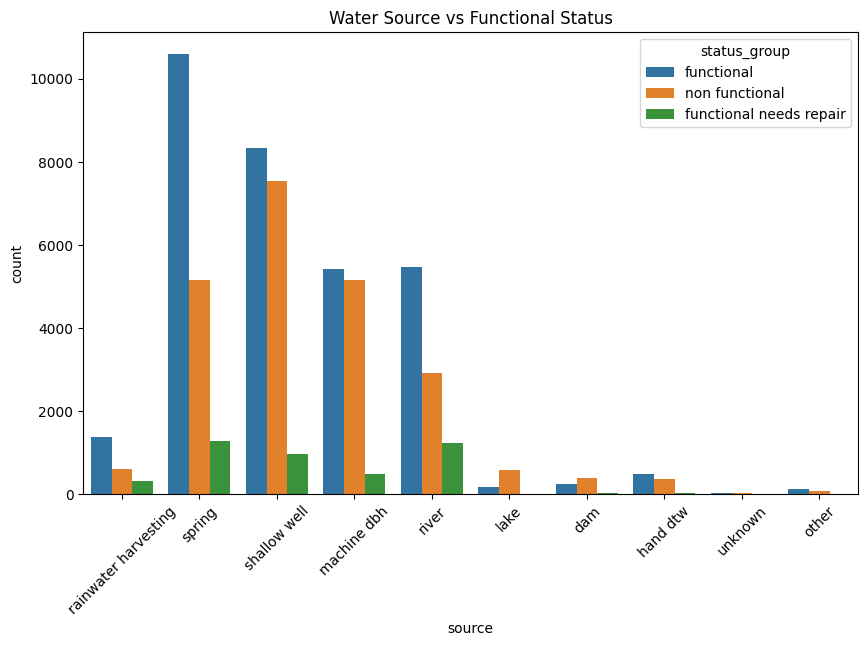

Chi-squared: 2623.998280150263, p-value: 0.0


In [109]:
from scipy.stats import chi2_contingency
# Visualize source vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source', hue='status_group', data=All_data)
plt.title('Water Source vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test example for 'source'
contingency_table = pd.crosstab(All_data['source'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")


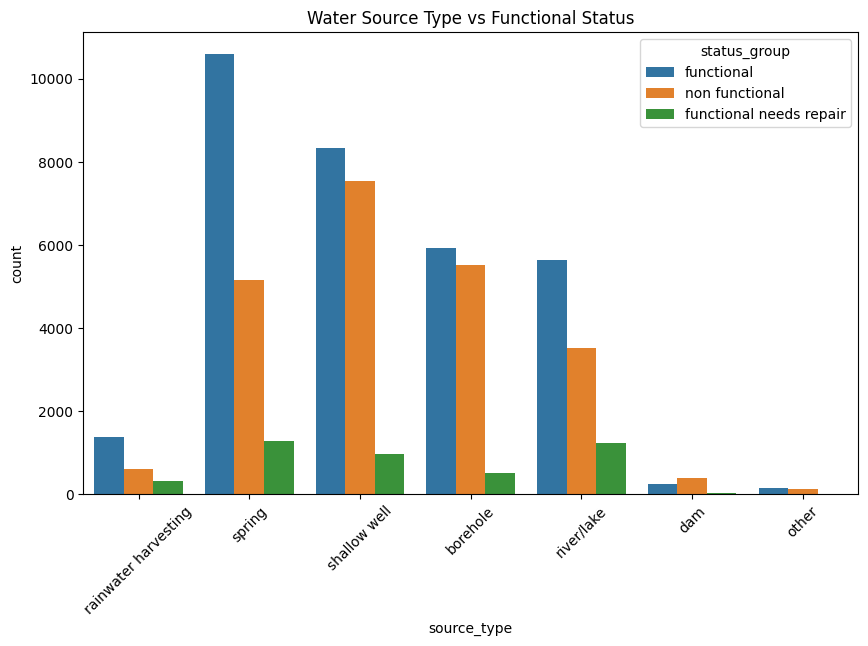

Chi-squared: 1906.7974141394534, p-value: 0.0


In [110]:
# Visualize source_type vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source_type', hue='status_group', data=All_data)
plt.title('Water Source Type vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_type'
contingency_table = pd.crosstab(All_data['source_type'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

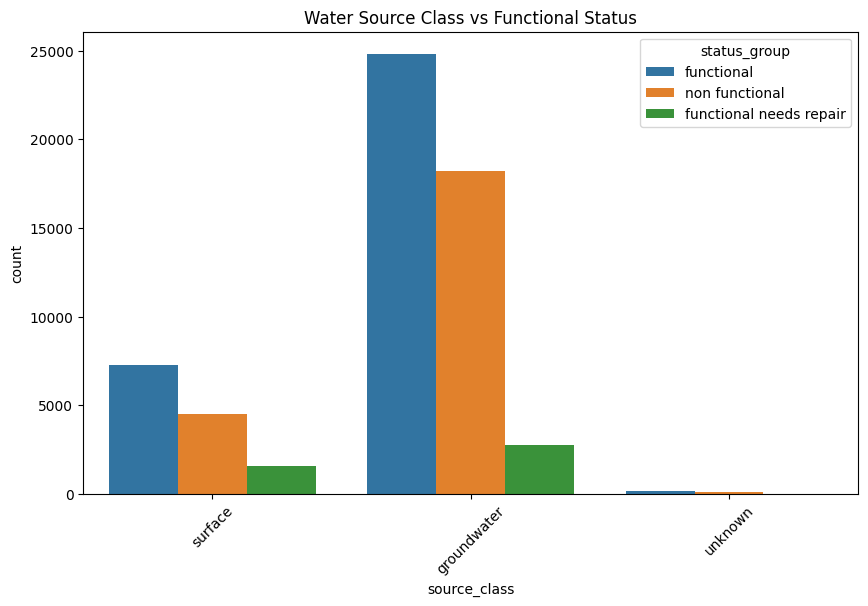

Chi-squared: 590.263287271222, p-value: 1.983538119535751e-126


In [111]:
# Visualize source_class vs status_group
plt.figure(figsize=(10, 6))
sns.countplot(x='source_class', hue='status_group', data=All_data)
plt.title('Water Source Class vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_class'
contingency_table = pd.crosstab(All_data['source_class'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

Based on the analysis I've conducted, it seems that the `source`, `source_type`, and `source_class` variables provide different levels of granularity about the source of water:

1. **Source** provides specific details such as 'spring', 'shallow well', etc., which are very granular and directly related to the physical source of the water.
2. **Source Type** is a slightly aggregated version of the `source` variable, combining closely related sources into groups like 'river/lake' or 'borehole'.
3. **Source Class** is the most aggregated, categorizing sources simply into broader classes like 'groundwater' and 'surface'.

The visualizations and the chi-squared test results strongly suggest that all three variables are significantly related to the functional status of the water points. However, `source` and `source_type` provide more detailed breakdowns and show distinctions between different water sources more clearly than `source_class`.

Choosing `source_type` can simplify the model and reduce potential overfitting while retaining enough meaningful information. It reduces complexity without losing significant granularity, as evidenced by the detailed chi-squared test results and its capacity to still differentiate well between functional statuses.

In [112]:
# Drop the 'source' and 'source_class' colunm
All_data.drop(columns=['source'], inplace=True)
All_data.drop(columns=['source_class'], inplace=True)

In [113]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['source_type'] ,dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... quantity_insufficient quantity_seasonal quantity_unknown  \
0  ...                   

In [114]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'scheme_management_Unknown',
       'scheme_management_VWC', 'scheme_management_WUG',
       'scheme_management_Water authority', 'management_vwc',
       'management_water board', 'management_wua', 'management_wug',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity

In [115]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'source_type_borehole')
calculate_zero_percentage(All_data, 'source_type_dam')
calculate_zero_percentage(All_data, 'source_type_other')
calculate_zero_percentage(All_data, 'source_type_rainwater harvesting')
calculate_zero_percentage(All_data, 'source_type_river/lake')
calculate_zero_percentage(All_data, 'source_type_shallow well')
calculate_zero_percentage(All_data, 'source_type_spring')

Percentage of 0s for source_type_borehole: 79.89%
Percentage of 0s for source_type_dam: 98.87%
Percentage of 0s for source_type_other: 99.53%
Percentage of 0s for source_type_rainwater harvesting: 96.14%
Percentage of 0s for source_type_river/lake: 82.61%
Percentage of 0s for source_type_shallow well: 71.53%
Percentage of 0s for source_type_spring: 71.43%


In [116]:
# Drop 'source_type_other' colunm
All_data.drop(columns=['source_type_other'], inplace=True)

In [117]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'scheme_management_Unknown',
       'scheme_management_VWC', 'scheme_management_WUG',
       'scheme_management_Water authority', 'management_vwc',
       'management_water board', 'management_wua', 'management_wug',
       'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity

**4.4 waterpoint_type, waterpoint_type_group**

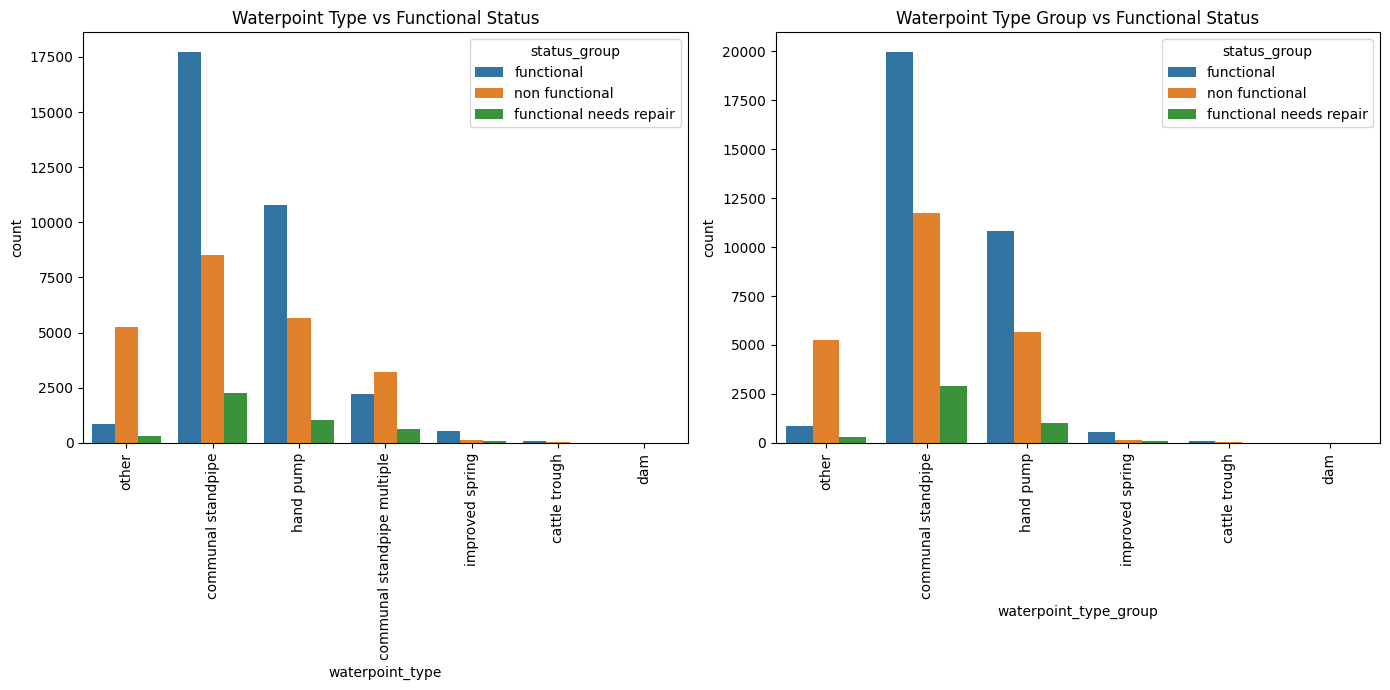

In [123]:
plt.figure(figsize=(14, 7))

# Waterpoint Type vs. Functional Status
plt.subplot(1, 2, 1)
sns.countplot(data=All_data, x='waterpoint_type', hue='status_group')
plt.title('Waterpoint Type vs Functional Status')
plt.xticks(rotation=90)

# Waterpoint Type Group vs. Functional Status
plt.subplot(1, 2, 2)
sns.countplot(data=All_data, x='waterpoint_type_group', hue='status_group')
plt.title('Waterpoint Type Group vs Functional Status')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Based on the visualizations, retaining the `waterpoint_type` variable would be the better choice. This is because `waterpoint_type` offers a more detailed categorization of the water sources, which provides a finer granularity in the analysis of the relationship between the type of waterpoint and its functional status. 

The granularity of `waterpoint_type` allows for more nuanced insights and decision-making regarding maintenance needs and functionality improvements specific to each type. For example, understanding the specific needs of hand pumps versus communal standpipes can direct targeted interventions that are more likely to improve functionality and longevity of the water sources.

Furthermore, the detailed breakdown in `waterpoint_type` enhances the ability to track performance and issues at a more granular level, which is critical for effective water resource management and planning. This can help in prioritizing which types need more attention or which are performing well under current conditions, thus contributing to better resource allocation and policy-making.

In [124]:
# Drop the 'waterpoint_type_group' colunm
All_data.drop(columns=['waterpoint_type_group'], inplace=True)

In [125]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['waterpoint_type'], dtype='int_')
print(All_data.head())

      id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... source_type_river/lake source_type_shallow well source_type_spring  \
0  ...         

In [126]:
# Print a list of all column names
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'status_group',
       'scheme_management_Unknown', 'scheme_management_VWC',
       'scheme_management_WUG', 'scheme_management_Water authority',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_type_annually', 'payment_type_monthly',
       'payment_type_never pay', 'payment_type_on failure',
       'payment_type_per bucket', 'payment_type_unknown', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity

In [127]:
def calculate_zero_percentage(df, column_name):
    count_series = df[column_name].value_counts(normalize=True) * 100
    zero_percentage = count_series.get(0, 0)
    print(f"Percentage of 0s for {column_name}: {zero_percentage:.2f}%")

calculate_zero_percentage(All_data, 'waterpoint_type_cattle trough')
calculate_zero_percentage(All_data, 'waterpoint_type_communal standpipe')
calculate_zero_percentage(All_data, 'waterpoint_type_communal standpipe multiple')
calculate_zero_percentage(All_data, 'waterpoint_type_dam')
calculate_zero_percentage(All_data, 'waterpoint_type_hand pump')
calculate_zero_percentage(All_data, 'waterpoint_type_improved spring')
calculate_zero_percentage(All_data, 'waterpoint_type_other')

Percentage of 0s for waterpoint_type_cattle trough: 99.80%
Percentage of 0s for waterpoint_type_communal standpipe: 52.02%
Percentage of 0s for waterpoint_type_communal standpipe multiple: 89.75%
Percentage of 0s for waterpoint_type_dam: 99.99%
Percentage of 0s for waterpoint_type_hand pump: 70.53%
Percentage of 0s for waterpoint_type_improved spring: 98.71%
Percentage of 0s for waterpoint_type_other: 89.21%


In [128]:
# Drop 'waterpoint_type_dam' and 'waterpoint_type_cattle trough' colunms
All_data.drop(columns=['waterpoint_type_cattle trough'], inplace=True)
All_data.drop(columns=['waterpoint_type_dam'], inplace=True)

**<h3>Save File<h3>**

In [129]:
All_data.to_csv('Values_Modify.csv')